# Reconcile Excluded Datasets Analysis

This notebook extends the analysis of `excluded_datasets_list.csv`: clarifies annual vs trend exclusions, regional breakdown, config validation, non-includable data structure, inclusion-fix impact, and reconciliation with the paper's "38 excluded" (Extended Data Fig. 1).

In [1]:
import pandas as pd
from pathlib import Path

base = Path('input/input_datasets') if (Path('input/input_datasets') / 'excluded_datasets_list.csv').exists() else Path('.')
df = pd.read_csv(base / 'excluded_datasets_list.csv')
print(f"Loaded {len(df)} rows. Columns: {list(df.columns)}")
df.head(10)

Loaded 142 rows. Columns: ['region', 'data_group', 'dataset', 'exclusion_type', 'inclusion_possible']


,region,data_group,dataset,exclusion_type,inclusion_possible
0,alaska,demdiff_and_glaciological,UZH_GlaciolSineWave,annual,yes
1,alaska,demdiff_and_glaciological,WGMS-mean_ba,annual,yes
2,alaska,gravimetry,Jacob_2012_dmdt,annual,yes
3,antarctic_and_subantarctic,altimetry,Gardner2013_icesat,annual,no
4,antarctic_and_subantarctic,altimetry,Khan,annual,yes
5,antarctic_and_subantarctic,demdiff_and_glaciological,UZH_GlaciolSineWave,annual,yes
6,antarctic_and_subantarctic,demdiff_and_glaciological,WGMS-mean_ba,annual,yes
7,arctic_canada_north,altimetry,Gardner2013_icesat,annual,yes
8,arctic_canada_north,altimetry,Khan,annual,no
9,arctic_canada_north,altimetry,Tepes,annual,yes


## 1. Annual vs Trend Exclusions

- **Annual exclusion**: Datasets with sub-annual or non-aligned temporal resolution that are excluded when the pipeline expects annual mass-balance time series. The fix `shift_timeseries_to_annual_grid_proportionally()` redistributes values to the annual grid so they can be used.
- **Trend exclusion**: The same datasets can also be excluded when used as long-period trends. These are already compatible with `convert_timeseries_to_annual_trends()`; hence all trend exclusions in our list are includable (no technical block).
- The glambie config YAMLs use `exclude_annual_datasets` and `exclude_trend_datasets` per data group; a given (region, dataset) can appear as both annual and trend exclusion.

In [2]:
# Crosstab: exclusion_type vs inclusion_possible
print(pd.crosstab(df['exclusion_type'], df['inclusion_possible'], margins=True))
print()

# (region, data_group, dataset) that appear as BOTH annual and trend
annual = set(df[df['exclusion_type'] == 'annual'].apply(lambda r: (r['region'], r['data_group'], r['dataset']), axis=1))
trend = set(df[df['exclusion_type'] == 'trend'].apply(lambda r: (r['region'], r['data_group'], r['dataset']), axis=1))
both = annual & trend
print(f"Exclusions that appear as both annual and trend (same region/data_group/dataset): {len(both)}")
if both:
    both_df = pd.DataFrame(sorted(both), columns=['region', 'data_group', 'dataset'])
    print(both_df.to_string(index=False))

inclusion_possible  no  yes  All
exclusion_type                  
annual              11   95  106
trend                0   36   36
All                 11  131  142

Exclusions that appear as both annual and trend (same region/data_group/dataset): 36
              region data_group              dataset
caucasus_middle_east gravimetry      Jacob_2012_dmdt
caucasus_middle_east gravimetry              Wouters
        central_asia  altimetry     Treichler_ICESat
        central_asia gravimetry          Harig_Group
        central_asia gravimetry      Jacob_2012_dmdt
        central_asia gravimetry Sasgen_AWIarc_RL01_2
        central_asia gravimetry              Wouters
      central_europe gravimetry      Jacob_2012_dmdt
      central_europe gravimetry Sasgen_AWIarc_RL01_2
      central_europe gravimetry              Wouters
       low_latitudes gravimetry      Jacob_2012_dmdt
       low_latitudes gravimetry Sasgen_AWIarc_RL01_2
       low_latitudes gravimetry              Wouters
       

## 2. Region-Level Breakdown

Exclusion count by region, non-includable by region, and data group coverage per region.

Excluded submissions per region (unique region × data_group × dataset):
region
central_asia                  9
western_canada_us             9
south_asia_east               8
south_asia_west               8
new_zealand                   6
arctic_canada_north           6
arctic_canada_south           6
scandinavia                   5
russian_arctic                5
iceland                       5
central_europe                5
svalbard                      5
north_asia                    5
greenland_periphery           5
antarctic_and_subantarctic    4
low_latitudes                 4
caucasus_middle_east          4
southern_andes                4
alaska                        3


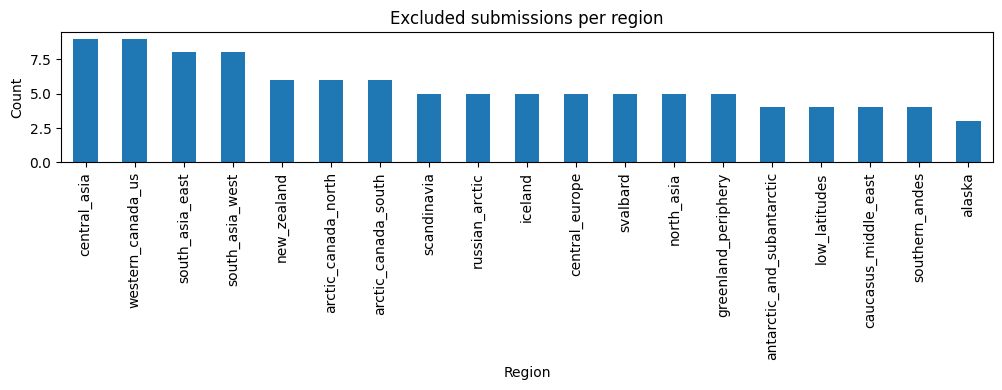

In [3]:
import matplotlib.pyplot as plt

# Exclusion count by region (unique region, data_group, dataset per region)
by_region = df.drop_duplicates(subset=['region', 'data_group', 'dataset']).groupby('region').size().sort_values(ascending=False)
print("Excluded submissions per region (unique region × data_group × dataset):")
print(by_region.to_string())
by_region.plot(kind='bar', title='Excluded submissions per region', xlabel='Region', ylabel='Count', figsize=(10, 4))
plt.tight_layout()
plt.show()

In [4]:
# Non-includable only (permanently blocked)
non_incl = df[df['inclusion_possible'] == 'no'].drop_duplicates(subset=['region', 'data_group', 'dataset'])
print("Non-includable exclusions by region:")
print(non_incl.groupby('region').size().sort_values(ascending=False).to_string())
print()

# Crosstab: region x data_group (excluded combinations)
ct = pd.crosstab(df['region'], df['data_group'])
print("Excluded (region × data_group) counts:")
print(ct)

Non-includable exclusions by region:
region
south_asia_east               2
greenland_periphery           2
central_asia                  2
south_asia_west               2
arctic_canada_south           1
antarctic_and_subantarctic    1
arctic_canada_north           1

Excluded (region × data_group) counts:
data_group                  altimetry  demdiff_and_glaciological  gravimetry
region                                                                      
alaska                              0                          2           1
antarctic_and_subantarctic          2                          2           0
arctic_canada_north                 3                          2           1
arctic_canada_south                 3                          2           1
caucasus_middle_east                0                          2           4
central_asia                        4                          2           8
central_europe                      0                          2           6

## 3. Validate Against Glambie Configs

Compare `exclude_annual_datasets` / `exclude_trend_datasets` from region config YAMLs with the excluded list filtered by region.

In [17]:
import yaml

config_dir = Path('input/glambie_runs/Reanalysis_RGI_6_default/configs')
if not config_dir.exists():
    config_dir = Path('../glambie_runs/Reanalysis_RGI_6_default/configs')
if not config_dir.exists():
    config_dir = base.parent / 'glambie_runs' / 'Reanalysis_RGI_6_default' / 'configs'

def get_config_excluded(region_name: str):
    """Map region_name to config file (e.g. central_asia -> central_asia.yaml)."""
    path = config_dir / f"{region_name}.yaml"
    if not path.exists():
        return None
    with open(path) as f:
        cfg = yaml.safe_load(f)
    out = {}
    for data_group, settings in cfg.get('region_run_settings', {}).items():
        annual = [x for x in (settings.get('exclude_annual_datasets') or []) if x and str(x).lower() != 'null']
        trend = [x for x in (settings.get('exclude_trend_datasets') or []) if x and str(x).lower() != 'null']
        if annual or trend:
            out[data_group] = {'exclude_annual_datasets': annual, 'exclude_trend_datasets': trend}
    return out

# Compare for central_asia and greenland_periphery
for reg in ['central_asia', 'greenland_periphery']:
    cfg_excl = get_config_excluded(reg)
    csv_reg = df[df['region'] == reg].drop_duplicates(subset=['data_group', 'dataset', 'exclusion_type'])
    print(f"--- {reg} ---")
    if cfg_excl is None:
        print("  Config not found.")
        continue
    for dg, lists in cfg_excl.items():
        csv_annual = set(csv_reg[(csv_reg['data_group'] == dg) & (csv_reg['exclusion_type'] == 'annual')]['dataset'].astype(str))
        csv_trend = set(csv_reg[(csv_reg['data_group'] == dg) & (csv_reg['exclusion_type'] == 'trend')]['dataset'].astype(str))
        cfg_annual = set(lists['exclude_annual_datasets'])
        cfg_trend = set(lists['exclude_trend_datasets'])
        if csv_annual != cfg_annual:
            print(f"  {dg} annual: CSV has {csv_annual - cfg_annual} not in config; config has {cfg_annual - csv_annual} not in CSV")
        if csv_trend != cfg_trend:
            print(f"  {dg} trend: CSV has {csv_trend - cfg_trend} not in config; config has {cfg_trend - csv_trend} not in CSV")
        if csv_annual == cfg_annual and csv_trend == cfg_trend:
            print(f"  {dg}: CSV and config match (annual: {sorted(cfg_annual)}, trend: {sorted(cfg_trend)})")
    print()

--- central_asia ---
  altimetry: CSV and config match (annual: ['Ke', 'Treichler_ICESat', 'Treichler_snowfall'], trend: ['Treichler_ICESat'])
  demdiff_and_glaciological: CSV and config match (annual: ['UZH_GlaciolSineWave', 'WGMS-mean_ba'], trend: [])
  gravimetry: CSV and config match (annual: ['Harig_Group', 'Jacob_2012_dmdt', 'Sasgen_AWIarc_RL01_2', 'Wouters'], trend: ['Harig_Group', 'Jacob_2012_dmdt', 'Sasgen_AWIarc_RL01_2', 'Wouters'])

--- greenland_periphery ---
  altimetry: CSV and config match (annual: ['Bolch_2013', 'Gardner2013_icesat', 'Khan'], trend: [])
  demdiff_and_glaciological: CSV and config match (annual: ['UZH_GlaciolSineWave', 'WGMS-mean_ba'], trend: [])



## 4. Non-Includable Data Structure

For each non-includable dataset (Treichler_snowfall, Treichler_ICESat, Khan, Gardner2013_icesat, Bolch_2013): load underlying CSVs where `inclusion_possible == 'no'`, report rows and date range; compare with same dataset in regions where includable.

In [6]:
# Non-includable datasets are all altimetry; CSV path: input_datasets/region/altimetry/Dataset.csv
root_ds = base if (base / 'alaska').exists() else Path('..')
non_incl_list = df[df['inclusion_possible'] == 'no'].drop_duplicates(subset=['region', 'data_group', 'dataset'])
results = []
for _, row in non_incl_list.iterrows():
    reg, dg, ds = row['region'], row['data_group'], row['dataset']
    path = root_ds / reg / 'altimetry' / f"{ds}.csv"
    if path.exists():
        t = pd.read_csv(path)
        start = t['start_dates'].min() if 'start_dates' in t.columns else None
        end = t['end_dates'].max() if 'end_dates' in t.columns else None
        results.append({'region': reg, 'dataset': ds, 'n_rows': len(t), 'start': start, 'end': end, 'inclusion': 'no'})
    else:
        results.append({'region': reg, 'dataset': ds, 'n_rows': None, 'start': None, 'end': None, 'inclusion': 'no'})

# Same datasets in regions where includable (for comparison)
yes_df = df[(df['inclusion_possible'] == 'yes') & (df['dataset'].isin(non_incl_list['dataset'].unique()))].drop_duplicates(subset=['region', 'dataset'])
for _, row in yes_df.iterrows():
    reg, ds = row['region'], row['dataset']
    path = root_ds / reg / 'altimetry' / f"{ds}.csv"
    if path.exists():
        t = pd.read_csv(path)
        results.append({'region': reg, 'dataset': ds, 'n_rows': len(t), 'start': t['start_dates'].min(), 'end': t['end_dates'].max(), 'inclusion': 'yes'})

summary = pd.DataFrame(results)
print("Non-includable (and includable same-dataset) CSV summary:")
print(summary.to_string())

Non-includable (and includable same-dataset) CSV summary:
                        region             dataset  n_rows        start          end inclusion
0   antarctic_and_subantarctic  Gardner2013_icesat       1  2003.786301  2009.786301        no
1          arctic_canada_north                Khan       3  2003.123288  2023.328767        no
2          arctic_canada_south                Khan       3  2003.123288  2023.328767        no
3                 central_asia    Treichler_ICESat       1  2003.805479  2008.852459        no
4                 central_asia  Treichler_snowfall       1  2003.805479  2008.852459        no
5          greenland_periphery          Bolch_2013       1  2003.747945  2008.163934        no
6          greenland_periphery  Gardner2013_icesat       1  2003.786301  2009.786301        no
7              south_asia_east    Treichler_ICESat       1  2003.805479  2008.852459        no
8              south_asia_east  Treichler_snowfall       1  2003.805479  2008.852459   

## 5. Impact of Inclusion Fix

Applying `shift_timeseries_to_annual_grid_proportionally()` would allow includable annual exclusions to run. Summary: how many combinations would become usable vs remain blocked.

In [7]:
# Before fix: all annual exclusions are excluded from the run
annual_df = df[df['exclusion_type'] == 'annual']
includable_annual = annual_df[annual_df['inclusion_possible'] == 'yes']
non_includable_annual = annual_df[annual_df['inclusion_possible'] == 'no']

print("Annual exclusions:")
print(f"  Total annual exclusion rows: {len(annual_df)}")
print(f"  Includable (could run with fix): {len(includable_annual)}")
print(f"  Non-includable (remain blocked): {len(non_includable_annual)}")
print()
print("Trend exclusions: all are includable (no fix needed).")
print(f"  Trend rows: {len(df[df['exclusion_type'] == 'trend'])}")
print()
print("Summary:")
print("  Before fix: 106 unique (region, data_group, dataset) excluded from combined estimate.")
print("  After fix: only the 11 non-includable (region, dataset) would remain blocked;")
print("  the ~95 includable annual exclusions could be included if the code change is applied.")

Annual exclusions:
  Total annual exclusion rows: 106
  Includable (could run with fix): 95
  Non-includable (remain blocked): 11

Trend exclusions: all are includable (no fix needed).
  Trend rows: 36

Summary:
  Before fix: 106 unique (region, data_group, dataset) excluded from combined estimate.
  After fix: only the 11 non-includable (region, dataset) would remain blocked;
  the ~95 includable annual exclusions could be included if the code change is applied.


## 6. Reconciling with Extended Data Fig. 1 (38 excluded)

The paper (GlaMBIE, Nature 2025) states: *From the 233 regional results, 195 (coloured lines) were used to compute our combined estimates, and 38 (grey lines) were excluded based on regional confidence levels of observation methods.*

- **233** = total regional results (research team submissions)
- **195** = used
- **38** = excluded

Our CSV counts exclusions at (region, data_group, dataset) granularity. We compute alternative counts and note why 38 ≠ our total.

In [8]:
# Our CSV counts
n_rows = len(df)
n_unique_submission = df.drop_duplicates(subset=['region', 'data_group', 'dataset']).shape[0]
n_unique_region_method = df.drop_duplicates(subset=['region', 'data_group']).shape[0]
n_non_includable = df[df['inclusion_possible'] == 'no'].drop_duplicates(subset=['region', 'data_group', 'dataset']).shape[0]

print("Our excluded list counts:")
print(f"  Rows (annual + trend duplicate entries): {n_rows}")
print(f"  Unique (region, data_group, dataset):    {n_unique_submission}  <- each excluded 'submission'")
print(f"  Unique (region, data_group):            {n_unique_region_method}  <- if paper counted per method per region")
print(f"  Non-includable unique:                  {n_non_includable}")
print()
print("Paper: 38 excluded regional results.")
print("Definitive reconciliation would require Supplementary Tables 1 and 2 (paper) to map submission IDs to our dataset names.")
print()
print("Possible reasons 106 ≠ 38:")
print("  1. Different granularity: paper may count (region, observation_method) not (region, dataset).")
print("  2. Different criteria: paper's 38 may be 'confidence-level' exclusions only; our CSV includes all algorithm exclusions.")
print("  3. Different compilation: our CSV reflects Reanalysis_RGI_6_including_most; paper's 233/195/38 from original GlaMBIE submission pool.")

Our excluded list counts:
  Rows (annual + trend duplicate entries): 142
  Unique (region, data_group, dataset):    106  <- each excluded 'submission'
  Unique (region, data_group):            47  <- if paper counted per method per region
  Non-includable unique:                  11

Paper: 38 excluded regional results.
Definitive reconciliation would require Supplementary Tables 1 and 2 (paper) to map submission IDs to our dataset names.

Possible reasons 106 ≠ 38:
  1. Different granularity: paper may count (region, observation_method) not (region, dataset).
  2. Different criteria: paper's 38 may be 'confidence-level' exclusions only; our CSV includes all algorithm exclusions.
  3. Different compilation: our CSV reflects Reanalysis_RGI_6_including_most; paper's 233/195/38 from original GlaMBIE submission pool.


## Optional: Visualizations

Stacked bar of exclusions by region and data group; small summary table for non-includable datasets.

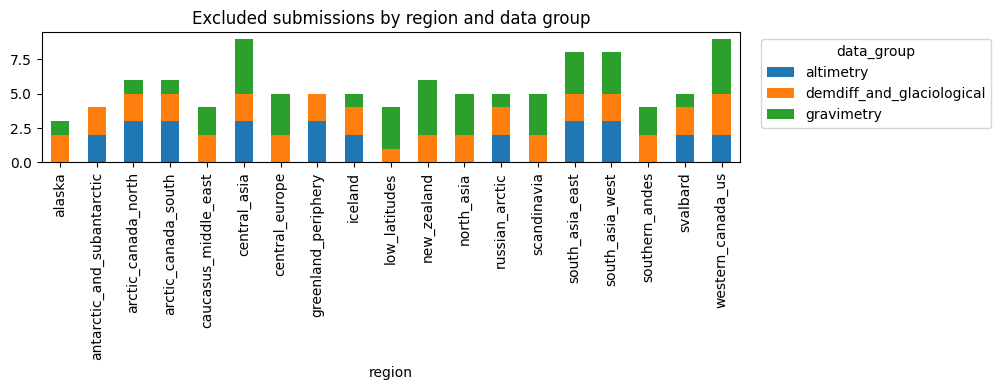

Non-includable datasets by region:
                    region            dataset
       greenland_periphery         Bolch_2013
antarctic_and_subantarctic Gardner2013_icesat
       greenland_periphery Gardner2013_icesat
       arctic_canada_north               Khan
       arctic_canada_south               Khan
              central_asia   Treichler_ICESat
           south_asia_east   Treichler_ICESat
           south_asia_west   Treichler_ICESat
              central_asia Treichler_snowfall
           south_asia_east Treichler_snowfall
           south_asia_west Treichler_snowfall


In [9]:
# Stacked bar: exclusions by region and data_group
u = df.drop_duplicates(subset=['region', 'data_group', 'dataset'])
pivot = u.pivot_table(index='region', columns='data_group', aggfunc='size', fill_value=0)
pivot.plot(kind='bar', stacked=True, figsize=(10, 4), title='Excluded submissions by region and data group')
plt.legend(title='data_group', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

# Summary table: non-includable datasets and regions
print("Non-includable datasets by region:")
print(non_incl_list[['region', 'dataset']].sort_values(['dataset', 'region']).to_string(index=False))